## Tutorial on how to combine different Fields into a `NestedField` object

In some applications, you may have access to different fields that each cover only part of the region of interest. Then, you would like to combine them all together. You may also have a field covering the entire region and another one only covering part of it, but with a higher resolution. The set of those fields form what we call nested fields.

It is possible to combine all those fields with kernels, either with different if/else statements depending on particle position, or using recovery kernels (if only two levels of nested fields).

However, an easier way to work with nested fields in Parcels is to combine all those fields into one `NestedField` object. The Parcels code will then try to successively interpolate the different fields. 

For each Particle, the algorithm is the following:

1. Interpolate the particle onto the first `Field` in the `NestedFields` list.

2. If the interpolation succeeds or if an error other than `ErrorOutOfBounds` is thrown, the function is stopped.

3. If an `ErrorOutOfBounds` is thrown, try step 1) again with the next `Field` in the `NestedFields` list 

4. If interpolation on the last `Field` in the `NestedFields` list also returns an `ErrorOutOfBounds`, then the Particle is flagged as OutOfBounds.

This algorithm means that **the order of the fields in the `NestedField` matters**. In particular, the smallest/finest resolution fields have to be listed _before_ the larger/coarser resolution fields.

This tutorial shows how to use these `NestedField` with a very idealised example.

In [1]:
%matplotlib inline
from parcels import Field, NestedField, FieldSet, ParticleSet, JITParticle, plotTrajectoriesFile, AdvectionRK4
import numpy as np

First define a zonal and meridional velocity field defined on a high resolution (dx = 100m) 2kmx2km grid with a flat mesh. The zonal velocity is uniform and 1 m/s, and the meridional velocity is equal to 0.5 * cos(lon / 200 * pi / 2) m/s.

In [2]:
dim = 21
lon = np.linspace(0., 2e3, dim, dtype=np.float32)
lat = np.linspace(0., 2e3, dim, dtype=np.float32)
lon_g, lat_g = np.meshgrid(lon, lat)
V1_data = .5*np.cos(lon_g / 200 * np.pi/2)
U1 = Field('U1', np.ones((dim, dim), dtype=np.float32), lon=lon, lat=lat)
V1 = Field('V1', V1_data, grid=U1.grid)

Now define the same velocity field on a low resolution (dx = 2km) 20kmx20km grid.

In [3]:
dim = 11
lon = np.linspace(0., 20e3, dim, dtype=np.float32)
lat = np.linspace(0., 20e3, dim, dtype=np.float32)
lon_g, lat_g = np.meshgrid(lon, lat)
V2_data = .5*np.cos(lon_g / 200 * np.pi/2)
U2 = Field('U2', np.ones((dim, dim), dtype=np.float32), lon=lon, lat=lat)
V2 = Field('V2', V2_data, grid=U2.grid)

We now combine those fields into a `NestedField` and create the fieldset

In [4]:
U = NestedField('U', [U1, U2])
V = NestedField('V', [V1, V2])
fieldset = FieldSet(U, V)

INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/h0/01fvrmn11qb62yjw7v1kn62r0000gq/T/parcels-503/3b9fbe7fb6d38c4c87ac6f6017636211.so


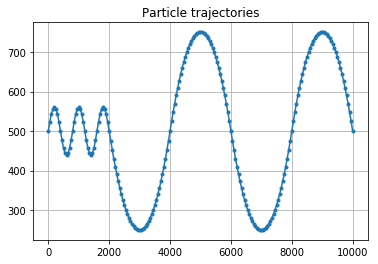

In [5]:
pset = ParticleSet(fieldset, pclass=JITParticle, lon=[0], lat=[500])
output_file = pset.ParticleFile(name='NestedFieldParticle.nc', outputdt=50)
pset.execute(AdvectionRK4, runtime=10000, dt=10, output_file=output_file)
plotTrajectoriesFile('NestedFieldParticle.nc');

As we observe, there is a change of dynamic at lon=2000, which corresponds to the change of grid.

The analytical solution to the problem:
\begin{align}
dx/dt &= 1\\
dy/dt &= 0.5 \cos(x \pi/400)\\
\text{with  } x(0) &= 0, y(0) = 500
\end{align}

is
\begin{align}
x(t) &= t\\
y(t) &= 500 + 200/\pi \sin(t \pi / 400)
\end{align}
which is captured by the High Resolution field but not the Low Resolution one.

### Keep track of the field interpolated

For different reasons, you may want to keep track of the field you have interpolated. You can do that easily by creating another field that share the grid with original fields.
Watch out that this operation has a cost of a full interpolation operation.

In [6]:
F1 = Field('F1', np.ones((U1.grid.ydim, U1.grid.xdim), dtype=np.float32), grid=U1.grid)
F2 = Field('F2', 2*np.ones((U2.grid.ydim, U2.grid.xdim), dtype=np.float32), grid=U2.grid)
F = NestedField('F', [F1, F2])
fieldset.add_field(F)

In [7]:
from parcels import Variable

def SampleNestedFieldIndex(particle, fieldset, time, dt):
    particle.f = fieldset.F[time, particle.lon, particle.lat, particle.depth]

class SampleParticle(JITParticle):
    f = Variable('f', dtype=np.int32)
    
pset = ParticleSet(fieldset, pclass= SampleParticle, lon=[0], lat=[500])
pset.execute(SampleNestedFieldIndex, runtime=0, dt=0)
print('Particle (%g, %g) interpolates Field #%d' % (pset[0].lon, pset[0].lat, pset[0].f))

pset[0].lon = 10000
pset.execute(SampleNestedFieldIndex, runtime=0, dt=0)
print('Particle (%g, %g) interpolates Field #%d' % (pset[0].lon, pset[0].lat, pset[0].f))


INFO: Compiled SampleParticleSampleNestedFieldIndex ==> /var/folders/h0/01fvrmn11qb62yjw7v1kn62r0000gq/T/parcels-503/f11a0f2e8057f47494303cfd2166c89c.so


Particle (0, 500) interpolates Field #1
Particle (10000, 500) interpolates Field #2
